# **Chatbot Menggunakan Model LSTM**

## **Import Libraries**

In [1]:
# Import Libraries
import json
import re
import numpy as np
import pandas as pd
import gdown

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.layers import Bidirectional

## **Mengekstrak Dataset**

In [2]:
# gdown for downloading files directly from Google Drive.
from gdown import download

id = "1t5jfyXEyE0ZA_LKqPvUjFCevbERhYZvZ"
output = "train-SQuAD-id.json"
download(id=id, output=output)

Downloading...
From: https://drive.google.com/uc?id=1t5jfyXEyE0ZA_LKqPvUjFCevbERhYZvZ
To: /content/train-SQuAD-id.json
100%|██████████| 37.9M/37.9M [00:00<00:00, 51.5MB/s]


'train-SQuAD-id.json'

In [3]:
# --- Memuat dan Mengekstrak Data dari File JSON ---
nama_file = 'train-SQuAD-id.json'

questions = []
answers = []

with open(nama_file, 'r', encoding='utf-8') as f:
    data_chatbot = json.load(f)

for article in data_chatbot['data']:
    for paragraph in article['paragraphs']:
        for qa in paragraph['qas']:
            if qa['answers']:
                questions.append(qa['question'])
                answers.append(qa['answers'][0]['text'])

print(f"Berhasil mengekstrak {len(questions)} pasang data tanya-jawab.")
print("\nContoh Pertanyaan:", questions[59])
print("Contoh Jawaban:", answers[59])

Berhasil mengekstrak 76444 pasang data tanya-jawab.

Contoh Pertanyaan: Di kota mana sekolah dasar Beyoncé berada?
Contoh Jawaban: Fredericksburg


## **Preprocessing Data**

In [4]:
# --- Fungsi untuk membersihkan teks ---
def clean_text(text):
    text = text.lower()  # Mengubah ke huruf kecil
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text) # Menghapus karakter khusus
    return text

# Membersihkan setiap pertanyaan dan jawaban
cleaned_questions = [clean_text(q) for q in questions]
cleaned_answers = [clean_text(a) for a in answers]

# Kita perlu menambahkan token <start> dan <end> pada jawaban
# agar model tahu kapan harus memulai dan mengakhiri sebuah kalimat.
cleaned_answers_input = ['<start> ' + text for text in cleaned_answers]
cleaned_answers_output = [text + ' <end>' for text in cleaned_answers]

print("\nContoh Pertanyaan (setelah dibersihkan):", cleaned_questions[59])
print("Contoh Jawaban (setelah dibersihkan):", cleaned_answers_input[59])


Contoh Pertanyaan (setelah dibersihkan): di kota mana sekolah dasar beyoncé berada
Contoh Jawaban (setelah dibersihkan): <start> fredericksburg


In [5]:
# --- Tokenisasi ---
# Gabungkan semua teks untuk membuat satu vocabulary
all_texts = cleaned_questions + cleaned_answers_input + cleaned_answers_output
tokenizer = Tokenizer(filters='', oov_token='<unk>')
tokenizer.fit_on_texts(all_texts)

vocab_size = len(tokenizer.word_index) + 1

# Mengubah teks menjadi urutan angka (sequences)
question_sequences = tokenizer.texts_to_sequences(cleaned_questions)
answer_sequences_input = tokenizer.texts_to_sequences(cleaned_answers_input)

# Menentukan panjang maksimum untuk padding
max_len_question = max(len(seq) for seq in question_sequences)
max_len_answer = max(len(seq) for seq in answer_sequences_input)
max_len = max(max_len_question, max_len_answer)

# --- Padding ---
# Membuat semua sequence memiliki panjang yang sama
X = pad_sequences(question_sequences, maxlen=max_len, padding='post')
y = pad_sequences(answer_sequences_input, maxlen=max_len, padding='post')

print("\nUkuran Vocabulary:", vocab_size)
print("Panjang Sequence Maksimal:", max_len)
print("\nContoh Question Sequence (setelah padding):\n", X[59])


Ukuran Vocabulary: 47469
Panjang Sequence Maksimal: 36

Contoh Question Sequence (setelah padding):
 [  6  33  16  86 348 776 146   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


## **Modelling**

In [6]:
# --- Membangun Model ---
embedding_dim = 128
lstm_units = 256

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(units=lstm_units, return_sequences=True),
    Dense(units=vocab_size, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
# --- Melatih Model ---
# Catatan: Jumlah epochs yang ideal bisa lebih dari 50,
# namun untuk percobaan awal, 10-20 sudah cukup untuk melihat hasilnya.
epochs = 30
batch_size = 64

history = model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/30
956/956 ━━━━━━━━━━━━━━━━━━━━ 274s 286ms/step - accuracy: 0.9204 - loss: 0.7765 - val_accuracy: 0.9177 - val_loss: 0.8419
Epoch 2/30
956/956 ━━━━━━━━━━━━━━━━━━━━ 273s 285ms/step - accuracy: 0.9203 - loss: 0.7386 - val_accuracy: 0.9181 - val_loss: 0.8387
Epoch 3/30
956/956 ━━━━━━━━━━━━━━━━━━━━ 273s 285ms/step - accuracy: 0.9209 - loss: 0.7049 - val_accuracy: 0.9181 - val_loss: 0.8454
Epoch 4/30
956/956 ━━━━━━━━━━━━━━━━━━━━ 321s 284ms/step - accuracy: 0.9203 - loss: 0.6828 - val_accuracy: 0.9180 - val_loss: 0.8553
Epoch 5/30
956/956 ━━━━━━━━━━━━━━━━━━━━ 322s 284ms/step - accuracy: 0.9205 - loss: 0.6564 - val_accuracy: 0.9182 - val_loss: 0.8686
Epoch 6/30
956/956 ━━━━━━━━━━━━━━━━━━━━ 273s 286ms/step - accuracy: 0.9214 - loss: 0.6245 - val_accuracy: 0.9180 - val_loss: 0.8863
Epoch 7/30
956/956 ━━━━━━━━━━━━━━━━━━━━ 273s 285ms/step - accuracy: 0.9210 - loss: 0.6016 - val_accuracy: 0.9176 - val_loss: 0.8940
Epoch 8/30
956/956 ━━━━━━━━━━━━━━━━━━━━ 273s 286ms/step - accuracy: 0.9217 -

## **Evaluasi dan Tes Chatbot**

In [11]:
# Membuat mapping dari index ke kata dan sebaliknya
word_to_index = tokenizer.word_index
index_to_word = {i: word for word, i in word_to_index.items()}

def chatbot_response(user_input):
    # 1. Bersihkan dan proses input pengguna
    cleaned_input = clean_text(user_input)
    input_seq = tokenizer.texts_to_sequences([cleaned_input])
    padded_input = pad_sequences(input_seq, maxlen=max_len, padding='post')

    # 2. Lakukan prediksi dengan model
    prediction = model.predict(padded_input)

    # 3. Ambil kata dengan probabilitas tertinggi untuk setiap posisi
    predicted_indices = np.argmax(prediction, axis=-1)[0]

    # 4. Ubah kembali dari index ke kata
    response_text = ''
    for index in predicted_indices:
        if index > 0: # Abaikan padding (index 0)
            word = index_to_word.get(index, '<unk>')
            if word == '<end>':
                break
            response_text += ' ' + word

    return response_text.strip()

# --- Mari Coba Chatbot! ---
print("\n--- Chatbot Siap! ---")
print("Ketik 'exit' untuk keluar.")

while True:
    user_query = input("Anda: ")
    if user_query.lower() == 'exit':
        break

    response = chatbot_response(user_query)
    print("Bot:", response)


--- Chatbot Siap! ---
Ketik 'exit' untuk keluar.
Anda: exit


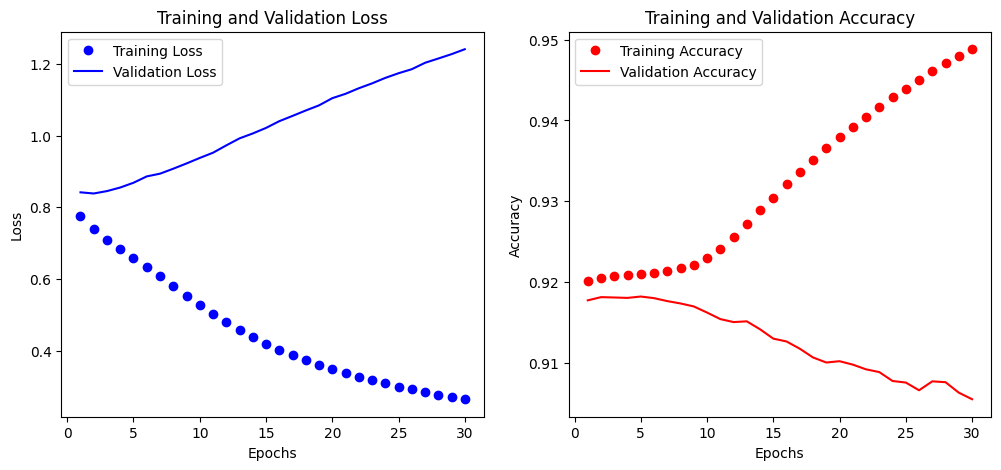

In [12]:
import matplotlib.pyplot as plt

# Mengekstrak data dari objek history
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs_range = range(1, len(accuracy) + 1)

# Membuat plot untuk Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss_values, 'bo', label='Training Loss')
plt.plot(epochs_range, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Membuat plot untuk Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy, 'ro', label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()